In [1]:
from sklearn.metrics import f1_score, accuracy_score
import numpy as np
import random, os
from tqdm import tqdm
# import tensorflow as tf
import torch
from IPython.display import clear_output
import transformers
import torch.nn as nn
import pandas as pd

torch.cuda.empty_cache()
import torch.nn.functional as F

from sklearn.utils.class_weight import compute_class_weight

# clear output
clear_output()

In [2]:
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONASSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(seed=99) 

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# Data

In [4]:
train_path = ("/home/phu.hoang/Documents/courses/NLP701/MBZ-NLP701/data/data-raw/train_only_aug.csv")
dev_path = ("/home/phu.hoang/Documents/courses/NLP701/MBZ-NLP701/data/data-raw/dev_raw.csv")
test_path = ("/home/phu.hoang/Documents/courses/NLP701/MBZ-NLP701/data/data-raw/test_raw.csv")

In [5]:
def to_sentiment(label):
    label = str(label)
    if label == 'very pos':
        return 4
    elif label == 'pos':
        return 3
    elif label == 'neu':
        return 2
    elif label == 'neg':
        return 1
    elif label == 'very neg':
        return 0
    
def prepare_data(file_path):
    col_names = ['text', 'label']
    df = pd.read_csv(file_path, names=col_names, header=None)
    
    # # remove nan
    df = df.dropna()
    df = df.reset_index(drop=True)

    # map label to num
    df['label'] = df.label.apply(to_sentiment)
    
    texts = df.text.tolist()
    labels = df.label.tolist()
    
    # convert labels to tensors
    labels = torch.tensor(labels)
    
    return texts, labels

# Dataloader function
class TextDataset(torch.utils.data.Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):      
        self.texts = [tokenizer(text, 
                                padding='max_length', 
                                max_length = max_len, 
                                truncation=True,
                                return_tensors="pt")for text in texts]
        self.labels = labels
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, index):
        return self.texts[index], self.labels[index] #  self.attention_mask[index], 

def create_dataloader(texts, labels, batch_size, tokenizer, max_len, shuffle=True):
    dataset = TextDataset(texts, labels, tokenizer, max_len)
    # return texts
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
    return dataloader

# Create model

In [6]:
class ResnetBlock(nn.Module):
    def __init__(self, channel_size, conv_size):
        super(ResnetBlock, self).__init__()
        self.channel_size = channel_size
        self.maxpool = nn.Sequential(
            nn.ConstantPad1d(padding=(0, 1), value=0),
            nn.MaxPool1d(kernel_size=3, stride=2)
        )
        self.conv = nn.Sequential(
            nn.BatchNorm1d(num_features=self.channel_size),
            nn.ReLU(inplace=True),
            nn.Conv1d(self.channel_size, self.channel_size,
                      kernel_size=conv_size, padding=1),
            nn.BatchNorm1d(num_features=self.channel_size),
            nn.ReLU(inplace=True),
            nn.Conv1d(self.channel_size, self.channel_size,
                      kernel_size=conv_size, padding=1),
            nn.BatchNorm1d(num_features=self.channel_size),
            nn.ReLU(inplace=True),
            nn.Conv1d(self.channel_size, self.channel_size,
                      kernel_size=conv_size, padding=1),
            nn.BatchNorm1d(num_features=self.channel_size),
            nn.ReLU(inplace=True),
            nn.Conv1d(self.channel_size, self.channel_size,
                      kernel_size=conv_size, padding=1),
            nn.BatchNorm1d(num_features=self.channel_size),
            nn.ReLU(inplace=True),
            nn.Conv1d(self.channel_size, self.channel_size,
                      kernel_size=conv_size, padding=1),
        )

    def forward(self, x):
        x_shortcut = self.maxpool(x)
        x = self.conv(x_shortcut)
        x = x + x_shortcut
        return x

class PLM_2DCNN(nn.Module):
    def __init__(self,
                 plm_model,
                 plm_drop_rate = 0.2,
                 emb_dim = 768,
                 conv_size = 3,
                 conv_filters = 250,
                 region_drop_rate = 0.5,
                 fc_drop_rate = 0, 
                 output_dim = 5
                 ):
        super(PLM_2DCNN, self).__init__()

        self.plm_model = plm_model
        self.emb_dim = emb_dim
        self.channel_size = conv_filters
        self.plm_model       = plm_model
        self.plm_drop_rate   = plm_drop_rate
        self.region_drop_rate = region_drop_rate
        self.output_dim = output_dim

        self.fc_input = nn.Linear(in_features=emb_dim, out_features=emb_dim)

        self.region_embedding = nn.Sequential(
                                            nn.Conv1d(in_channels= self.emb_dim, 
                                                    out_channels= self.channel_size, 
                                                    kernel_size = conv_size,
                                                    padding=1,
                                                    ),
                                            nn.BatchNorm1d(num_features=self.channel_size),
                                            nn.ReLU(inplace=True),
                                            nn.Dropout(self.region_drop_rate)
                                        )
        self.conv_block = nn.Sequential(
                            nn.BatchNorm1d(num_features=self.channel_size),
                            nn.ReLU(inplace=True),
                            nn.Conv1d(self.channel_size, self.channel_size,
                                    kernel_size=conv_size, padding=1),
                            nn.BatchNorm1d(num_features=self.channel_size),
                            nn.ReLU(inplace=True),
                            nn.Conv1d(self.channel_size, self.channel_size,
                                    kernel_size=conv_size, padding=1),
                        )
        
        resnet_block_list = []
        for i in range(6):
            resnet_block_list.append(ResnetBlock(self.channel_size, conv_size))
        
        self.resnet_layer = nn.Sequential(*resnet_block_list)

        self.fc = nn.Sequential(
            nn.Linear(self.channel_size, self.channel_size),
            nn.BatchNorm1d(self.channel_size),
            nn.ReLU(inplace=True),
            nn.Dropout(fc_drop_rate),
            nn.Linear(self.channel_size, self.output_dim)
        )


    def __call__(self, input_ids, attention_mask):
        self._last_hidden_state = self._create_plm_layer(plm_model= self.plm_model,
                                                        plm_drop_rate= self.plm_drop_rate,
                                                        input_ids= input_ids,
                                                        attention_mask= attention_mask)
        # print('Last hidden state:', self._last_hidden_state.shape)
        self._flattened_ts = self._create_dpnn_layer(self._last_hidden_state)

        return self._flattened_ts
    
    def _create_plm_layer(self, plm_model, plm_drop_rate, input_ids, attention_mask):
        # get output of plm_model: logis and last hidden state
        # with torch.no_grad():
        output = plm_model(input_ids = input_ids,
                            attention_mask = attention_mask,
                            return_dict = False)
        dropout = nn.Dropout(plm_drop_rate)
        last_hidden_state = output[0]

        return dropout(last_hidden_state)

    def _create_dpnn_layer(self, x):
        # print(x.shape)

        batch = x.shape[0]
        
        x= x.permute(0, 2, 1)
        x = self.region_embedding(x)
        x_re = self.conv_block(x)      
        x = x+x_re  
        x = self.resnet_layer(x)
        x = x.permute(0, 2, 1)
        x = x.contiguous().view(batch, -1)
        out = self.fc(x)
        
        return out

In [7]:
# class ResnetBlock(nn.Module):
#     def __init__(self, channel_size):
#         super(ResnetBlock, self).__init__()
#         self.channel_size = channel_size
#         self.maxpool = nn.Sequential(
#             nn.ConstantPad1d(padding=(0, 1), value=0),
#             nn.MaxPool1d(kernel_size=3, stride=2)
#         )
#         self.conv = nn.Sequential(
#             nn.BatchNorm1d(num_features=self.channel_size),
#             nn.ReLU(),
#             nn.Conv1d(self.channel_size, self.channel_size,
#                       kernel_size=3, padding=1),
#             nn.BatchNorm1d(num_features=self.channel_size),
#             nn.ReLU(),
#             nn.Conv1d(self.channel_size, self.channel_size,
#                       kernel_size=3, padding=1),
#         )

#     def forward(self, x):
#         x_shortcut = self.maxpool(x)
#         x = self.conv(x_shortcut)
#         x = x + x_shortcut
#         return x

# class PLM_CNN(nn.Module):
#     def __init__(self,
#                  plm_model,
#                  plm_drop_rate = 0.2,
#                  embedding_dim = 768,
#                  filter_sizes = [1,2,3,4],
#                  n_filters = 250,
#                  dropout = 0.1,
#                  output_dim = 5
#                  ):
#         super(PLM_CNN, self).__init__()

#         self.plm_model = plm_model
#         self.plm_drop_rate = plm_drop_rate

#         self.conv_0 = nn.Conv1d(in_channels=embedding_dim, out_channels=n_filters, kernel_size=filter_sizes[0])
#         self.bn_0 = nn.BatchNorm1d(n_filters)
#         self.residual_0 = nn.Sequential(
#             nn.Conv1d(in_channels=n_filters, out_channels=n_filters, kernel_size=3, padding=1),
#             nn.BatchNorm1d(n_filters),
#             nn.ELU(),
#             nn.Conv1d(in_channels=n_filters, out_channels=n_filters, kernel_size=3, padding=1),
#             nn.BatchNorm1d(n_filters)
#         )
        
#         self.conv_1 = nn.Conv1d(in_channels=embedding_dim, out_channels=n_filters, kernel_size=filter_sizes[1])
#         self.bn_1 = nn.BatchNorm1d(n_filters)
#         self.residual_1 = nn.Sequential(
#             nn.Conv1d(in_channels=n_filters, out_channels=n_filters, kernel_size=3, padding=1),
#             nn.BatchNorm1d(n_filters),
#             nn.ELU(),
#             nn.Conv1d(in_channels=n_filters, out_channels=n_filters, kernel_size=3, padding=1),
#             nn.BatchNorm1d(n_filters)
#         )
        
#         self.conv_2 = nn.Conv1d(in_channels=embedding_dim, out_channels=n_filters, kernel_size=filter_sizes[2])
#         self.bn_2 = nn.BatchNorm1d(n_filters)
#         self.residual_2 = nn.Sequential(
#             nn.Conv1d(in_channels=n_filters, out_channels=n_filters, kernel_size=3, padding=1),
#             nn.BatchNorm1d(n_filters),
#             nn.ELU(),
#             nn.Conv1d(in_channels=n_filters, out_channels=n_filters, kernel_size=3, padding=1),
#             nn.BatchNorm1d(n_filters)
#         )
        
#         self.conv_3 = nn.Conv1d(in_channels=embedding_dim, out_channels=n_filters, kernel_size=filter_sizes[3])
#         self.bn_3 = nn.BatchNorm1d(n_filters)
#         self.residual_3 = nn.Sequential(
#             nn.Conv1d(in_channels=n_filters, out_channels=n_filters, kernel_size=3, padding=1),
#             nn.BatchNorm1d(n_filters),
#             nn.ELU(),
#             nn.Conv1d(in_channels=n_filters, out_channels=n_filters, kernel_size=3, padding=1),
#             nn.BatchNorm1d(n_filters)
#         )

#         self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)
#         self.dropout = nn.Dropout(dropout)
        
#         nn.init.kaiming_uniform_(self.conv_0.weight)
#         nn.init.kaiming_uniform_(self.conv_1.weight)
#         nn.init.kaiming_uniform_(self.conv_2.weight)
#         nn.init.kaiming_uniform_(self.conv_3.weight)
#         nn.init.kaiming_uniform_(self.fc.weight)


#     def __call__(self, input_ids, attention_mask):
#         self._last_hidden_state = self._create_plm_layer(plm_model= self.plm_model,
#                                                         plm_drop_rate= self.plm_drop_rate,
#                                                         input_ids= input_ids,
#                                                         attention_mask= attention_mask)
#         # print('Last hidden state:', self._last_hidden_state.shape)
#         self._flattened_ts = self._create_dpnn_layer(self._last_hidden_state)

#         return self._flattened_ts
    
#     def _create_plm_layer(self, plm_model, plm_drop_rate, input_ids, attention_mask):
#         # get output of plm_model: logis and last hidden state
#         # with torch.no_grad():
#         output = plm_model(input_ids = input_ids,
#                             # attention_mask = attention_mask,
#                             return_dict = False)
#         dropout = nn.Dropout(plm_drop_rate)
#         last_hidden_state = output[0]

#         return dropout(last_hidden_state)

#     def _create_dpnn_layer(self, x):
#         # print(x.shape)

#         x = x.permute(0, 2, 1)
        
#         # x = [batch size, sent len, emb dim]
        
#         x0 = F.relu(self.bn_0(self.conv_0(x)))
#         x0 = self.bn_0(self.residual_0(x0) + x0)
#         x1 = F.relu(self.bn_1(self.conv_1(x)))
#         x1 = self.bn_1(self.residual_1(x1) + x1)
#         x2 = F.relu(self.bn_2(self.conv_2(x)))
#         x2 = self.bn_2(self.residual_2(x2) + x2)
#         x3 = F.relu(self.bn_3(self.conv_3(x)))
#         x3 = self.bn_3(self.residual_3(x3) + x3)
        
#         # xN = [batch size, n_filters, sent len - filter_sizes[n] + 1]
        
#         pooled_0 = F.max_pool1d(x0, x0.shape[2]).squeeze(2)
#         pooled_1 = F.max_pool1d(x1, x1.shape[2]).squeeze(2)
#         pooled_2 = F.max_pool1d(x2, x2.shape[2]).squeeze(2)
#         pooled_3 = F.max_pool1d(x3, x3.shape[2]).squeeze(2)
        
#         # print(x0.shape, x1.shape, x2.shape, x3.shape)
        
#         x = torch.cat((pooled_0, pooled_1, pooled_2, pooled_3), dim=1).cuda()
        
#         # x = [batch size, n_filters * len(filter_sizes)]
        
#         x = x.view(-1, x.shape[1])
        
#         x = self.dropout(x)
        
#         x = self.fc(x)
        
#         return x

In [8]:
# import optim
import torch.optim as optim
_softmax = nn.Softmax(dim = 1)
from collections import defaultdict
from sklearn.metrics import accuracy_score
history = defaultdict(list)

def train(model,
          train_dataloader,
          dev_dataloader,
          criterion_label,
          optimizer_label,
          num_epoches,
          early_stopping = 10, 
          best_label = 0,
          history = history):

    best_model = None
    best_label = 0
    best_loss = 0
    stopping_count = 0

    scheduler_label_RLROP = optim.lr_scheduler.ReduceLROnPlateau(optimizer_label, 
                                                                 'min',
                                                                 factor=0.1,
                                                                 patience=5)
    
    for epoch in range(num_epoches):

        model.train()
        
        train_losses = []
        y_true = []
        y_pred = []
        print('Epoch: ', epoch+1)
        
        for texts, labels in tqdm(train_dataloader):

            optimizer_label.zero_grad(set_to_none=True) 
            
            input_ids = texts['input_ids'].squeeze(1).to(device)
            attention_mask = texts['attention_mask'].to(device)
            labels = labels.type(torch.LongTensor)
            labels = labels.to(device) 
            label_logits = model(input_ids, attention_mask) 
              
            loss_label = criterion_label(label_logits.squeeze(), labels)
            
            _, preds = torch.max(_softmax(label_logits), dim=1)
            preds = preds.cpu().detach()
            target = labels.cpu().detach()         
            y_pred.extend(preds.tolist())
            y_true.extend(target.tolist())

            train_losses.append(loss_label.item())
            
            loss_label.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)
            optimizer_label.step() 

        train_acc = accuracy_score(y_true,y_pred)              

        model.eval()         
        # Calculate validation loss and macro F1-score
        val_losses = []
        y_true = []
        y_pred = []

        with torch.no_grad():
            for texts, labels in tqdm(dev_dataloader):                  
                
                input_ids = texts['input_ids'].squeeze(1).to(device)
                attention_mask = texts['attention_mask'].to(device)
                labels = labels.type(torch.LongTensor)
                labels = labels.to(device) 
                label_logits = model(input_ids, attention_mask) 

                loss_label = criterion_label(label_logits.squeeze(), labels)                
                val_losses.append(loss_label.item())
                    
                _, preds = torch.max(_softmax(label_logits), dim=1)
                preds = preds.cpu().detach()
                target = labels.cpu().detach()         
                y_pred.extend(preds.tolist())
                y_true.extend(target.tolist())
        
        dev_acc = accuracy_score(y_true,y_pred)      

        train_loss = np.mean(train_losses)
        dev_loss = np.mean(val_losses)

        if best_label < dev_acc:
            best_label = dev_acc
        
        if epoch == 0:
            best_loss = dev_loss
            torch.save(model.state_dict(), '/home/phu.hoang/Documents/courses/NLP701/MBZ-NLP701/data/models/saved_models/best_spans_model.pt')
        elif best_loss > dev_loss:
            best_loss = dev_loss
            stopping_count = 0
            torch.save(model.state_dict(), '/home/phu.hoang/Documents/courses/NLP701/MBZ-NLP701/data/models/saved_models/best_spans_model.pt')
        else:
            stopping_count+=1

        print('Training loss: ', train_loss)
        print('Train accuracy: ', train_acc)
        print('----')
        print('Dev acc: ', dev_acc)
        print('Validation loss: ', dev_loss)
        print('----')
        print('Best label Acc-score: ', best_label)
        print('stopping_count: ', stopping_count)      

        history['train_acc'].append(train_acc)
        history['train_loss'].append(train_loss.item())
        history['val_acc'].append(dev_acc)
        history['val_loss'].append(dev_loss.item())

        scheduler_label_RLROP.step(dev_loss)

        if stopping_count == early_stopping:
            print('early_stopping reached! Done')
            break

    return history


In [9]:
def test(model,
          test_dataloader):
    y_true = []
    y_pred = []

    with torch.no_grad():
        for texts, labels in tqdm(test_dataloader):                  
            
            input_ids = texts['input_ids'].squeeze(1).to(device)
            attention_mask = texts['attention_mask'].to(device)
            labels = labels.type(torch.LongTensor)
            labels = labels.to(device) 
            label_logits = model(input_ids, attention_mask) 
                
            _, preds = torch.max(_softmax(label_logits), dim=1)
            preds = preds.cpu().detach()
            target = labels.cpu().detach()         
            y_pred.extend(preds.tolist())
            y_true.extend(target.tolist())
    
    test_acc = accuracy_score(y_true,y_pred)  

    print('Test acc: ', test_acc)

# Training

In [10]:
from transformers import (
    AutoModel, AutoConfig, XLMRobertaModel,
    AutoTokenizer, AutoModelForSequenceClassification
)
id2label = {0: 'very neg', 1: 'neg', 2: 'neu', 3: 'pos', 4: 'very pos'}
label2id = {'very neg': 0, 'neg': 1,'neu': 2, 'pos': 3, 'very pos': 4}
input_model = XLMRobertaModel.from_pretrained("xlm-roberta-base")
tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-base")

# Freeze most layers
for param in input_model.base_model.parameters():
    param.requires_grad = False

# Unfreeze the last N layers
N = 4
for param in input_model.base_model.encoder.layer[-N:].parameters():
    param.requires_grad = True

clear_output()

In [11]:
# """This module defines a configurable SSTDataset class."""

# import pytreebank
# import torch
# # from loguru import logger
# from transformers import AutoTokenizer
# from torch.utils.data import Dataset

# # logger.info("Loading SST")
# sst = pytreebank.load_sst()


# def rpad(array, n=70):
#     """Right padding."""
#     current_len = len(array)
#     if current_len > n:
#         return array[: n - 1]
#     extra = n - current_len
#     return array + ([0] * extra)


# def get_binary_label(label):
#     """Convert fine-grained label to binary label."""
#     if label < 2:
#         return 0
#     if label > 2:
#         return 1
#     raise ValueError("Invalid label")


# class SSTDataset(Dataset):
#     """Configurable SST Dataset.
    
#     Things we can configure:
#         - split (train / val / test)
#         - root / all nodes
#         - binary / fine-grained
#     """

#     def __init__(self, split="train", root=True, binary=True, max_len = 66):
#         """Initializes the dataset with given configuration.

#         Args:
#             split: str
#                 Dataset split, one of [train, val, test]
#             root: bool
#                 If true, only use root nodes. Else, use all nodes.
#             binary: bool
#                 If true, use binary labels. Else, use fine-grained.
#         """
#         # logger.info(f"Loading SST {split} set")
#         self.sst = sst[split]

#         # logger.info("Tokenizing")
#         if root and binary:
#             self.data = [
#                 (
#                     tokenizer("[CLS] " + tree.to_lines()[0] + " [SEP]", 
#                                 padding='max_length', 
#                                 max_length = max_len, 
#                                 truncation=True,
#                                 return_tensors="pt"),
#                     get_binary_label(tree.label),
#                 )
#                 for tree in self.sst
#                 if tree.label != 2
#             ]
#         elif root and not binary:
#             self.data = [
#                 (
#                     tokenizer("[CLS] " + tree.to_lines()[0] + " [SEP]", 
#                                 padding='max_length', 
#                                 max_length = max_len, 
#                                 truncation=True,
#                                 return_tensors="pt"),
#                     tree.label,
#                 )
#                 for tree in self.sst
#             ]
#         elif not root and not binary:
#             self.data = [
#                 (tokenizer("[CLS] " + line + " [SEP]", 
#                                 padding='max_length', 
#                                 max_length = max_len, 
#                                 truncation=True,
#                                 return_tensors="pt"), label)
#                 for tree in self.sst
#                 for label, line in tree.to_labeled_lines()
#             ]
#         else:
#             self.data = [
#                 (
#                     tokenizer("[CLS] " + line + " [SEP]", 
#                                 padding='max_length', 
#                                 max_length = max_len, 
#                                 truncation=True,
#                                 return_tensors="pt"),
#                     get_binary_label(label),
#                 )
#                 for tree in self.sst
#                 for label, line in tree.to_labeled_lines()
#                 if label != 2
#             ]

#     def __len__(self):
#         return len(self.data)

#     def __getitem__(self, index):
#         X, y = self.data[index]
#         # X = torch.tensor(X)
#         return X, y
    
# root = True
# binary = False
# trainset = SSTDataset("train", root=root, binary=binary)
# devset = SSTDataset("dev", root=root, binary=binary)
# testset = SSTDataset("test", root=root, binary=binary)

# batch_size = 64

# train_dataloader =  torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
# dev_dataloader =  torch.utils.data.DataLoader(devset, batch_size=batch_size, shuffle=True)
# test_dataloader =  torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True)

In [12]:
batch_size = 64
max_len = 66
train_dataloader = create_dataloader(*prepare_data(train_path), batch_size=batch_size, tokenizer = tokenizer, max_len=max_len, shuffle=True)
dev_dataloader = create_dataloader(*prepare_data(dev_path), batch_size=batch_size, tokenizer = tokenizer, max_len=max_len, shuffle=False)
test_dataloader = create_dataloader(*prepare_data(test_path), batch_size=batch_size, tokenizer = tokenizer, max_len=max_len)

In [13]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        torch.nn.init.normal_(m.weight, 1.0, 0.02)
        torch.nn.init.zeros_(m.bias)

In [14]:
# Set the number of epochs and the device to use for training
num_epochs = 200
plm_drop_rate = 0
conv_size = 3
emb_dim = 768
conv_filters = 300
region_drop_rate = 0
fc_drop_rate = 0
lr = 7e-6
weight_decay = 1e-5
output_dim = 5
early_stopping = 10

# Create an instance of the plm-2dcnn model
plm_2dcnn_model = PLM_2DCNN(plm_model=input_model,
                      plm_drop_rate= plm_drop_rate,
                      emb_dim = emb_dim,
                      conv_size = conv_size,
                      conv_filters = conv_filters,
                      region_drop_rate = region_drop_rate,
                      fc_drop_rate = fc_drop_rate,
                      output_dim = output_dim
                      )

plm_2dcnn_model.to(device)
plm_2dcnn_model.apply(weights_init)

## Define the loss functions
_, labels = prepare_data(train_path)
#compute the class weights
class_weights = compute_class_weight(class_weight = 'balanced', 
                                     classes = np.unique(labels), 
                                     y = labels.tolist())
print("Class Weights:",class_weights)
# converting list of class weights to a tensor
weights= torch.tensor(class_weights,dtype=torch.float)
# push to GPU
weights = weights.to(device)
# define the loss function
criterion_label = nn.CrossEntropyLoss(weight=weights) 

# Define the optimizeer
optimizer_label = optim.Adam(plm_2dcnn_model.parameters(),
                             lr=lr,
                             weight_decay = 0.3)


Class Weights: [1.56587156 0.77056433 1.05163278 0.7360069  1.32618493]


In [15]:
history = train(model=plm_2dcnn_model,
                  train_dataloader=train_dataloader,
                  dev_dataloader=dev_dataloader,
                  criterion_label=criterion_label,
                  optimizer_label=optimizer_label,
                  num_epoches=num_epochs,
                  early_stopping=early_stopping)

Epoch:  1


100%|██████████| 18/18 [00:01<00:00, 11.50it/s]


Training loss:  1.6650015600081505
Train accuracy:  0.18347785329271152
----
Dev acc:  0.17454545454545456
Validation loss:  1.6939477390713162
----
Best label Acc-score:  0.17454545454545456
stopping_count:  0
Epoch:  2


100%|██████████| 18/18 [00:01<00:00, 12.12it/s]


Training loss:  1.6451712873564668
Train accuracy:  0.18598546988516523
----
Dev acc:  0.22727272727272727
Validation loss:  1.6811910337871976
----
Best label Acc-score:  0.22727272727272727
stopping_count:  0
Epoch:  3


100%|██████████| 18/18 [00:01<00:00, 12.02it/s]


Training loss:  1.6300035019864565
Train accuracy:  0.19104757440824935
----
Dev acc:  0.25363636363636366
Validation loss:  1.6744923724068537
----
Best label Acc-score:  0.25363636363636366
stopping_count:  0
Epoch:  4


100%|██████████| 18/18 [00:01<00:00, 12.07it/s]


Training loss:  1.621973359066507
Train accuracy:  0.19163346613545817
----
Dev acc:  0.25363636363636366
Validation loss:  1.650635090139177
----
Best label Acc-score:  0.25363636363636366
stopping_count:  0
Epoch:  5


100%|██████████| 18/18 [00:01<00:00, 12.05it/s]


Training loss:  1.6159393485339506
Train accuracy:  0.19831263182563863
----
Dev acc:  0.25363636363636366
Validation loss:  1.6452597114774916
----
Best label Acc-score:  0.25363636363636366
stopping_count:  0
Epoch:  6


100%|██████████| 18/18 [00:01<00:00, 12.13it/s]


Training loss:  1.6120964996460854
Train accuracy:  0.20201546754159833
----
Dev acc:  0.25363636363636366
Validation loss:  1.647410598066118
----
Best label Acc-score:  0.25363636363636366
stopping_count:  1
Epoch:  7


100%|██████████| 18/18 [00:01<00:00, 12.06it/s]


Training loss:  1.6100813280874822
Train accuracy:  0.20278884462151395
----
Dev acc:  0.25363636363636366
Validation loss:  1.637021799882253
----
Best label Acc-score:  0.25363636363636366
stopping_count:  0
Epoch:  8


100%|██████████| 18/18 [00:01<00:00, 12.07it/s]


Training loss:  1.609319115328467
Train accuracy:  0.20456995547222873
----
Dev acc:  0.25272727272727274
Validation loss:  1.6205479039086237
----
Best label Acc-score:  0.25363636363636366
stopping_count:  0
Epoch:  9


100%|██████████| 18/18 [00:01<00:00, 12.07it/s]


Training loss:  1.6075474188245575
Train accuracy:  0.21150691352238107
----
Dev acc:  0.2545454545454545
Validation loss:  1.6171685258547466
----
Best label Acc-score:  0.2545454545454545
stopping_count:  0
Epoch:  10


100%|██████████| 18/18 [00:01<00:00, 12.06it/s]


Training loss:  1.6064610685008218
Train accuracy:  0.21492852120928052
----
Dev acc:  0.1809090909090909
Validation loss:  1.6133685111999512
----
Best label Acc-score:  0.2545454545454545
stopping_count:  0
Epoch:  11


100%|██████████| 18/18 [00:01<00:00, 11.93it/s]


Training loss:  1.6045835289819308
Train accuracy:  0.22191235059760955
----
Dev acc:  0.25636363636363635
Validation loss:  1.6107202635871039
----
Best label Acc-score:  0.25636363636363635
stopping_count:  0
Epoch:  12


100%|██████████| 18/18 [00:01<00:00, 12.07it/s]


Training loss:  1.5936122360615537
Train accuracy:  0.2409186782282634
----
Dev acc:  0.27454545454545454
Validation loss:  1.5671361552344427
----
Best label Acc-score:  0.27454545454545454
stopping_count:  0
Epoch:  13


100%|██████████| 18/18 [00:01<00:00, 12.06it/s]


Training loss:  1.5490526061008
Train accuracy:  0.26402624794937896
----
Dev acc:  0.25545454545454543
Validation loss:  1.504560477203793
----
Best label Acc-score:  0.27454545454545454
stopping_count:  0
Epoch:  14


100%|██████████| 18/18 [00:01<00:00, 12.13it/s]


Training loss:  1.5275663015903205
Train accuracy:  0.25732364659011014
----
Dev acc:  0.2881818181818182
Validation loss:  1.487134873867035
----
Best label Acc-score:  0.2881818181818182
stopping_count:  0
Epoch:  15


100%|██████████| 18/18 [00:01<00:00, 12.07it/s]


Training loss:  1.5205788188788487
Train accuracy:  0.24757440824935553
----
Dev acc:  0.3463636363636364
Validation loss:  1.519807669851515
----
Best label Acc-score:  0.3463636363636364
stopping_count:  1
Epoch:  16


100%|██████████| 18/18 [00:01<00:00, 12.08it/s]


Training loss:  1.5226399601846263
Train accuracy:  0.2394422310756972
----
Dev acc:  0.2690909090909091
Validation loss:  1.5201434757974412
----
Best label Acc-score:  0.3463636363636364
stopping_count:  2
Epoch:  17


100%|██████████| 18/18 [00:01<00:00, 12.07it/s]


Training loss:  1.5233064208967217
Train accuracy:  0.23665338645418327
----
Dev acc:  0.25
Validation loss:  1.4898036983278062
----
Best label Acc-score:  0.3463636363636364
stopping_count:  3
Epoch:  18


100%|██████████| 18/18 [00:01<00:00, 12.07it/s]


Training loss:  1.5269359850633268
Train accuracy:  0.23726271385048042
----
Dev acc:  0.24545454545454545
Validation loss:  1.5129791365729437
----
Best label Acc-score:  0.3463636363636364
stopping_count:  4
Epoch:  19


100%|██████████| 18/18 [00:01<00:00, 12.11it/s]


Training loss:  1.5323478569691327
Train accuracy:  0.23611436606515115
----
Dev acc:  0.24545454545454545
Validation loss:  1.51282446914249
----
Best label Acc-score:  0.3463636363636364
stopping_count:  5
Epoch:  20


100%|██████████| 18/18 [00:01<00:00, 12.06it/s]


Training loss:  1.5330307649886947
Train accuracy:  0.23937192406843216
----
Dev acc:  0.26636363636363636
Validation loss:  1.5445188615057204
----
Best label Acc-score:  0.3463636363636364
stopping_count:  6
Epoch:  21


100%|██████████| 18/18 [00:01<00:00, 12.08it/s]


Training loss:  1.531971333266377
Train accuracy:  0.24478556362784157
----
Dev acc:  0.24909090909090909
Validation loss:  1.5196164382828607
----
Best label Acc-score:  0.3463636363636364
stopping_count:  7
Epoch:  22


100%|██████████| 18/18 [00:01<00:00, 12.12it/s]


Training loss:  1.5318322725024358
Train accuracy:  0.24480899929692992
----
Dev acc:  0.2509090909090909
Validation loss:  1.516021404001448
----
Best label Acc-score:  0.3463636363636364
stopping_count:  8
Epoch:  23


100%|██████████| 18/18 [00:01<00:00, 12.07it/s]


Training loss:  1.5347052503382785
Train accuracy:  0.24509022732599015
----
Dev acc:  0.24363636363636362
Validation loss:  1.5244579646322463
----
Best label Acc-score:  0.3463636363636364
stopping_count:  9
Epoch:  24


100%|██████████| 18/18 [00:01<00:00, 12.13it/s]

Training loss:  1.5381176443114273
Train accuracy:  0.24532458401687368
----
Dev acc:  0.25636363636363635
Validation loss:  1.528730418947008
----
Best label Acc-score:  0.3463636363636364
stopping_count:  10
early_stopping reached! Done


In [16]:
model_path = '/home/phu.hoang/Documents/courses/NLP701/MBZ-NLP701/data/models/saved_models/best_spans_model.pt'
num_epochs = 50
plm_drop_rate = 0
conv_size = 3
emb_dim = 768
conv_filters = 300
region_drop_rate = 0
fc_drop_rate = 0
lr = 5e-6
weight_decay = 1e-5
output_dim = 5
early_stopping = 10

# Create an instance of the plm-2dcnn model
plm_2dcnn_model = PLM_2DCNN(plm_model=input_model,
                      plm_drop_rate= plm_drop_rate,
                      emb_dim = emb_dim,
                      conv_size = conv_size,
                      conv_filters = conv_filters,
                      region_drop_rate = region_drop_rate,
                      fc_drop_rate = fc_drop_rate,
                      output_dim = output_dim
                      )
plm_2dcnn_model.to(device)
plm_2dcnn_model.load_state_dict(torch.load(model_path))

test(model = plm_2dcnn_model,test_dataloader=test_dataloader)


100%|██████████| 35/35 [00:03<00:00, 11.32it/s]

Test acc:  0.3040723981900452


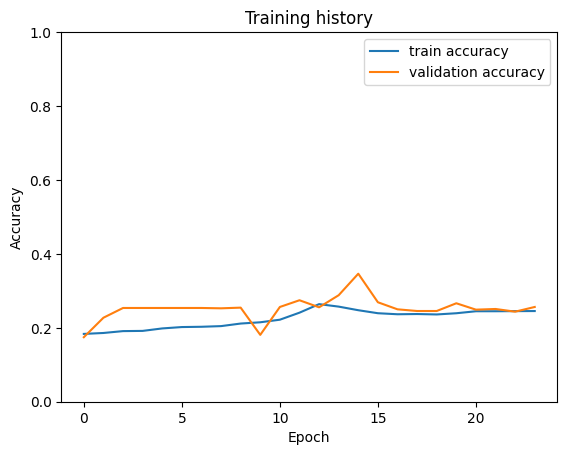

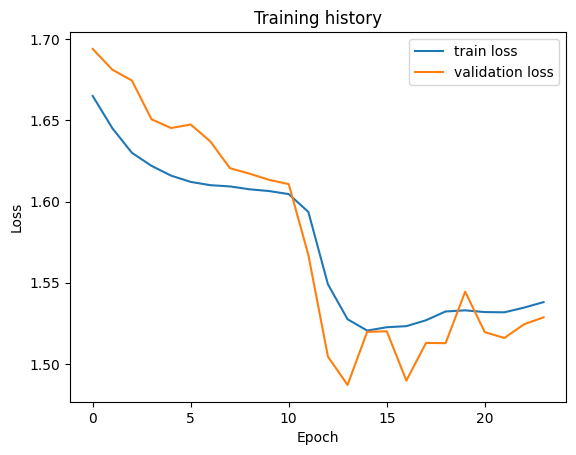

In [17]:
#DPCNN
import matplotlib.pyplot as plt

def show_how_it_learns_acc(history):
    plt.figure()
    plt.plot(history['train_acc'], label='train accuracy')
    plt.plot(history['val_acc'], label='validation accuracy')

    plt.title('Training history')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    plt.ylim([0, 1])

def show_how_it_learns_loss(history):
    plt.figure()
    plt.plot(history['train_loss'], label='train loss')
    plt.plot(history['val_loss'], label='validation loss')

    plt.title('Training history')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()

show_how_it_learns_acc(history)
show_how_it_learns_loss(history)